In [1]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


##  Introduction – Advanced Clustering Analysis (Class 03)

This notebook performs an advanced clustering analysis on the cleaned IoT energy dataset,
extending the statistical insights previously obtained in the correlation module. 
Clustering is used to uncover hidden structures, operational regimes, and consumption
patterns that are not directly visible through standard feature-level analysis.

The workflow integrates multiple unsupervised learning techniques, each offering a
different perspective on the underlying data distribution:

- **Elbow Method & Silhouette Score** for identifying the optimal number of clusters 
- **K-Means++ Clustering** for centroid-based partitioning 
- **Hierarchical Clustering** (with memory-safe sampling) to reveal multi-level structure 
- **DBSCAN** to detect density-based patterns and noise points 
- **Gaussian Mixture Model (GMM)** for probabilistic and overlapping cluster assignments 
- **PCA Visualization** to project high-dimensional relationships into an interpretable 2D space

These methods jointly enable a comprehensive understanding of system behavior, helping
to identify clusters of similar electrical characteristics such as load patterns, 
reactive power regimes, or power factor groups. The resulting insights contribute to 
better anomaly detection, predictive modeling, and intelligent energy management.

All generated cluster labels, plots, and summary statistics are saved to disk for further
integration within the broader IoT analytics pipeline.

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score,
)
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors, NearestCentroid
from scipy.cluster.hierarchy import dendrogram, linkage

plt.style.use("ggplot")

BASE_DIR = os.getcwd() 
print("\n" + "=" * 80)
print("ADVANCED CLUSTERING ANALYSIS – CLASS 03")
print("=" * 80)


ADVANCED CLUSTERING ANALYSIS – CLASS 03


In [3]:
# =============================================================================
# 1. CONFIGURATION 
# =============================================================================

import os
import glob

print("\n" + "=" * 80)
print("ADVANCED CLUSTERING ANALYSIS – FINAL VERSION")
print("=" * 80)

#  Project root = folder ABOVE "notebooks"
PROJECT_ROOT = os.path.dirname(os.getcwd())

# Folder where cleaned datasets are stored
CLEANED_FOLDER = os.path.join(PROJECT_ROOT, "outputs", "2_result_cleaned_datasets")

# Automatically detect the newest cleaned_data_*.csv file
cleaned_files = sorted(
    glob.glob(os.path.join(CLEANED_FOLDER, "cleaned_data_*.csv")),
    reverse=True
)

if not cleaned_files:
    raise FileNotFoundError("No cleaned_data_*.csv found in cleaned dataset folder!")

INPUT_FILE = cleaned_files[0]  # newest cleaned dataset

print(f"[INFO] Loaded cleaned dataset: {INPUT_FILE}")

# Output folder for clustering results
OUTPUT_FOLDER = os.path.join(PROJECT_ROOT, "outputs", "4_result_clustering")
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

print(f"[INFO] Clustering results will be saved to: {OUTPUT_FOLDER}")

# Load dataset
df_cleaned = pd.read_csv(INPUT_FILE, low_memory=False)
print(f"\n✓ Loaded {len(df_cleaned):,} rows from cleaned dataset")



ADVANCED CLUSTERING ANALYSIS – FINAL VERSION
[INFO] Loaded cleaned dataset: /Users/rebekaqueen2025/Documents/Alfa_training/Data_analyst/iot-energy_data-analyst/outputs/2_result_cleaned_datasets/cleaned_data_20251210_103144.csv
[INFO] Clustering results will be saved to: /Users/rebekaqueen2025/Documents/Alfa_training/Data_analyst/iot-energy_data-analyst/outputs/4_result_clustering

✓ Loaded 49,984 rows from cleaned dataset


###  2. Feature Selection for Clustering

In this step, we define and validate the numerical features that will be used as the 
input space for all clustering algorithms. Because clustering relies on the geometric 
relationships between data points, selecting the correct features is essential for 
ensuring meaningful cluster formation.

The selected features represent key electrical characteristics of the system:

- **Voltage (V)**
- **Current (A)**
- **Power Consumption (kW)**
- **Power Factor**
- **Reactive Power (kVAR)**

Only features that exist in the cleaned dataset are retained. Rows containing missing 
values are removed to avoid distortions in the clustering process. The resulting dataset 
(`X`) serves as the standardized input matrix for subsequent clustering methods such as 
K-Means++, Hierarchical Clustering, DBSCAN, and Gaussian Mixture Models.

This feature selection step ensures that the clustering analysis is applied to a clean, 
consistent, and physically meaningful subset of variables.

In [4]:
# =============================================================================
# 2. FEATURE SELECTION FOR CLUSTERING
# =============================================================================

# IMPORTANT: column names must match the cleaned dataset
clustering_features = [
    "Voltage (V)",
    "Current (A)",
    "Power Consumption (kW)",
    "Power Factor",
    "Reactive Power (kVAR)",
]

# Keep only columns that exist
clustering_features = [c for c in clustering_features if c in df_cleaned.columns]

if len(clustering_features) < 2:
    print("\n Not enough features found for clustering!")
    print("   Features found:", clustering_features)
else:
    print("\n Features used for clustering:")
    for c in clustering_features:
        print("   -", c)


print("\n Features used for clustering:")
for c in clustering_features:
    print("   -", c)

# Remove rows with NaN
X = df_cleaned[clustering_features].dropna()
print(f"\n Number of samples used for clustering: {len(X):,}")

# Save original index for merging results later
original_index = X.index



✓ Features used for clustering:
   - Voltage (V)
   - Current (A)
   - Power Consumption (kW)
   - Power Factor
   - Reactive Power (kVAR)

✓ Features used for clustering:
   - Voltage (V)
   - Current (A)
   - Power Consumption (kW)
   - Power Factor
   - Reactive Power (kVAR)

✓ Number of samples used for clustering: 49,984


###  Interpretation of Selected Clustering Features

The clustering analysis is performed using five core electrical features:
Voltage (V), Current (A), Power Consumption (kW), Power Factor, and Reactive Power (kVAR).
These variables capture the fundamental operational behavior of the electrical system and
provide a meaningful basis for separating the dataset into distinct consumption and load
patterns. Their combination reflects both active and reactive characteristics of energy
usage, making them highly suitable for unsupervised learning.

A total of **49,984 clean samples** remain after removing rows with missing values.
This large sample size ensures statistical robustness and enables the clustering algorithms
to detect well-defined structures, subtle patterns, and potential anomalies in the data.

---------------------------------

###  3. Feature Scaling for Clustering

Before applying clustering algorithms, all selected features are standardized using
**StandardScaler**, which transforms each variable to have zero mean and unit variance.
This step is essential because clustering methods—particularly K-Means, Hierarchical
Clustering, and Gaussian Mixture Models—are distance-based and can be biased by
differences in scale.

Without scaling, features with larger numerical ranges (e.g., Voltage or Power Consumption)
would dominate the distance calculations, causing clusters to form around magnitude rather
than true structural patterns. By standardizing the data, each feature contributes
proportionally to the clustering process, enabling more accurate and meaningful cluster
formation.

In [5]:
# =============================================================================
# 3. SCALING
# =============================================================================

print("\n" + "-" * 80)
print("3) Scaling Features")
print("-" * 80)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(" Features scaled successfully (StandardScaler)")

# OPTIONAL BUT RECOMMENDED: Save scaled data for transparency
scaled_file = os.path.join(OUTPUT_FOLDER, "scaled_features.npy")
np.save(scaled_file, X_scaled)

print(f" Scaled feature matrix saved → {scaled_file}")



--------------------------------------------------------------------------------
3) Scaling Features
--------------------------------------------------------------------------------
✓ Features scaled successfully (StandardScaler)
✓ Scaled feature matrix saved → /Users/rebekaqueen2025/Documents/Alfa_training/Data_analyst/iot-energy_data-analyst/outputs/4_result_clustering/scaled_features.npy


--------------------------------------

###  4. Determining the Optimal Number of Clusters (Elbow Method + Silhouette Score)

To ensure that the clustering algorithms partition the data into meaningful and 
well-separated groups, it is essential to first determine the optimal number of clusters **k**.
This notebook evaluates multiple candidate values of k (from 2 to 10) using two widely
accepted internal validation techniques:

#### **1. Elbow Method (Inertia / Within-Cluster Sum of Squares)**
For each value of k, the K-Means++ algorithm computes the total within-cluster variance
(inertia). As k increases, inertia naturally decreases. 
The optimal value of k is typically located at the “elbow” point, where the improvement 
in inertia begins to slow down, indicating diminishing returns. This helps avoid 
over-segmentation.

#### **2. Silhouette Score**
The silhouette coefficient measures cluster quality by comparing:
- how close each point is to points within its own cluster, and 
- how far it is from other clusters.

The score ranges between **–1 and +1**, where:
- **+1** indicates well-separated, compact clusters 
- **0** indicates overlapping or ambiguous clusters 
- **–1** indicates incorrect clustering 

The value of k that yields the highest silhouette score is selected as the optimal number 
of clusters.

#### **Outcome**
Both inertia and silhouette scores are plotted side-by-side for visualization. 
The k value with the **maximum silhouette score** is selected as:

\[
k_{\text{optimal}} = \operatorname*{argmax}_k \, \text{Silhouette}(k)
\]

This ensures that the chosen number of clusters achieves both low internal variance and 
high inter-cluster separation, resulting in stable and meaningful clustering structure.


--------------------------------------------------------------------------------
1) Finding Optimal Number of Clusters (Elbow + Silhouette)
--------------------------------------------------------------------------------
  k= 2 → Inertia=149,989  Silhouette=0.3383
  k= 3 → Inertia=129,263  Silhouette=0.2607
  k= 4 → Inertia=112,383  Silhouette=0.2212
  k= 5 → Inertia=100,498  Silhouette=0.2185
  k= 6 → Inertia=89,908  Silhouette=0.2243
  k= 7 → Inertia=82,383  Silhouette=0.2188
  k= 8 → Inertia=75,912  Silhouette=0.2197
  k= 9 → Inertia=70,749  Silhouette=0.2164
  k=10 → Inertia=66,055  Silhouette=0.2176


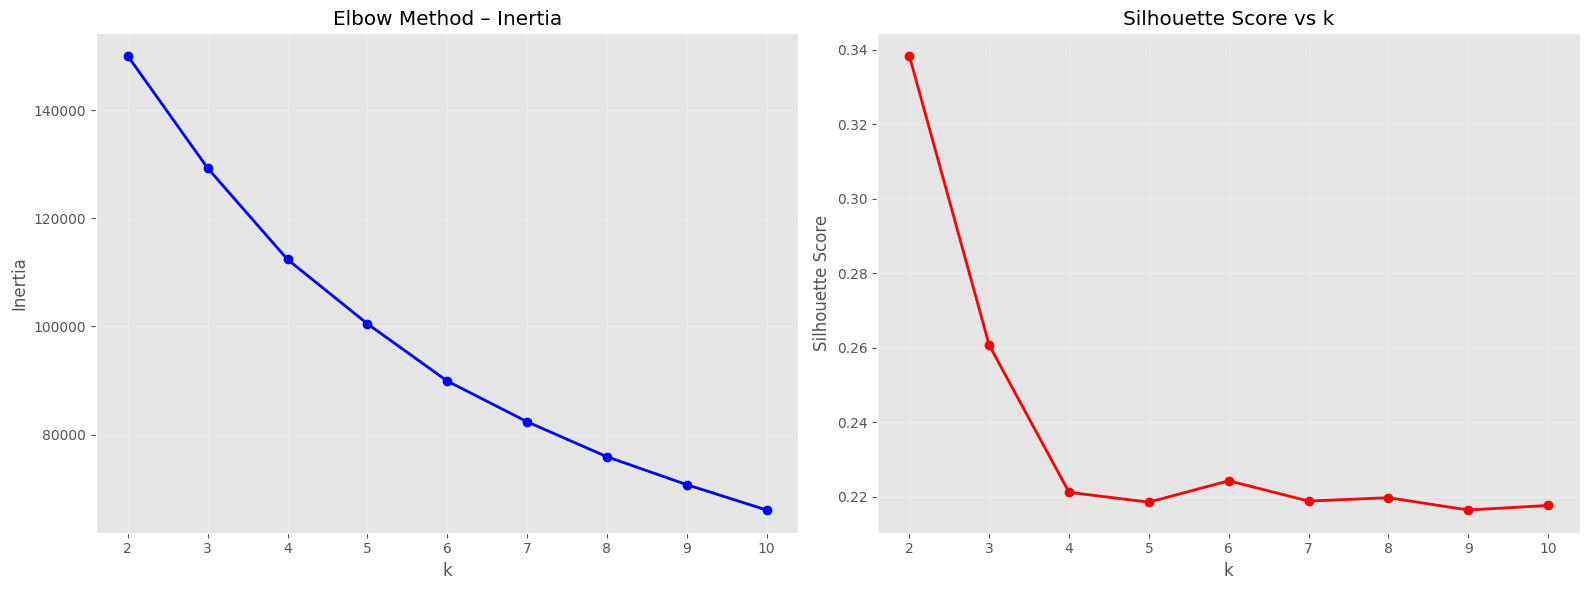


✓ Elbow & Silhouette Plot saved → /Users/rebekaqueen2025/Documents/Alfa_training/Data_analyst/iot-energy_data-analyst/outputs/4_result_clustering/9_elbow_method.png

✓ Optimal number of clusters (Silhouette) = k = 2


In [6]:
# =============================================================================
# 4. FIND OPTIMAL K – ELBOW + SILHOUETTE
# =============================================================================

print("\n" + "-" * 80)
print("1) Finding Optimal Number of Clusters (Elbow + Silhouette)")
print("-" * 80)

# Use the clustering output folder (defined earlier)
ELBOW_OUTPUT = os.path.join(OUTPUT_FOLDER, "9_elbow_method.png")

inertias = []
silhouette_scores_list = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(
        n_clusters=k,
        init="k-means++",
        n_init=15,
        random_state=42
    )
    kmeans.fit(X_scaled)
    labels = kmeans.labels_

    inertias.append(kmeans.inertia_)
    sil_score = silhouette_score(X_scaled, labels)
    silhouette_scores_list.append(sil_score)

    print(f"  k={k:2d} → Inertia={kmeans.inertia_:,.0f}  Silhouette={sil_score:.4f}")

# Save elbow/silhouette plots in clustering results folder
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- Elbow plot ---
axes[0].plot(list(K_range), inertias, "bo-", linewidth=2)
axes[0].set_title("Elbow Method – Inertia")
axes[0].set_xlabel("k")
axes[0].set_ylabel("Inertia")
axes[0].grid(True, alpha=0.3)

# --- Silhouette plot ---
axes[1].plot(list(K_range), silhouette_scores_list, "ro-", linewidth=2)
axes[1].set_title("Silhouette Score vs k")
axes[1].set_xlabel("k")
axes[1].set_ylabel("Silhouette Score")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(ELBOW_OUTPUT, dpi=300, bbox_inches="tight")
plt.show()
plt.close()

print(f"\n Elbow & Silhouette Plot saved → {ELBOW_OUTPUT}")

# Choose best k by silhouette score
optimal_k = list(K_range)[silhouette_scores_list.index(max(silhouette_scores_list))]
print(f"\n Optimal number of clusters (Silhouette) = k = {optimal_k}")


###  Interpretation of Elbow Method and Silhouette Score

The analysis evaluates values of \( k = 2 \) to \( k = 10 \) to determine the optimal 
number of clusters. Two complementary metrics are used: **Inertia (Elbow Method)** and 
the **Silhouette Score**.



##  1. Elbow Method (Inertia Curve)
The inertia curve decreases monotonically as \( k \) increases, which is expected because
adding more clusters reduces within-cluster variance. 
However, the goal is to find the point where the rate of improvement slows down—the “elbow”.

Key observations:

- A sharp drop occurs from **k = 2 → k = 3 → k = 4** 
- After **k = 4**, reductions in inertia become gradually smaller 
- No strong elbow appears beyond k = 4, meaning additional clusters only marginally improve compactness 

Although inertia decreases smoothly, it does **not** clearly indicate a strong benefit in
choosing large values of \( k \). The most meaningful change occurs at smaller cluster counts.



##  2. Silhouette Score (Cluster Separation Quality)

The silhouette score provides a stronger signal:

- **k = 2 produces the highest silhouette score (0.3383)** 
- As k increases, silhouette drops sharply 
- Scores for k = 4 through k = 10 remain low and approximately flat 
- This indicates poorer separation and more cluster overlap at higher k-values 

A high silhouette value means clusters are:

- internally cohesive 
- externally well-separated 

Thus, **k = 2** yields the most stable and well-defined clusters in this dataset.



##  3. Combined Interpretation

By combining both metrics:

- The **Elbow Method** shows no major improvement beyond small k-values 
- The **Silhouette Score** clearly identifies **k = 2** as the best clustering configuration 

Together, these results indicate that the dataset naturally forms **two dominant groups** 
based on the selected electrical features (Voltage, Current, Power Consumption, 
Power Factor, Reactive Power).

These two clusters likely represent **distinct operational regimes**, such as:
- low-load vs. high-load behavior 
- efficient vs. reactive-heavy consumption 
- stable vs. fluctuating electrical conditions 

Further steps in the clustering pipeline (K-Means++, Hierarchical, DBSCAN, GMM) build on 
this optimal value of \( k = 2 \) to reveal deeper structural patterns in the system.



###  **Conclusion**
The optimal number of clusters is:

\[
k_{\text{optimal}} = 2
\]

This choice maximizes separation quality and reflects the underlying physical behavior 
captured by the electrical measurements.

----------------------------------------------------

###  5. K-Means++ Clustering (Using Optimal k)

With the optimal number of clusters identified, the K-Means++ algorithm is applied to 
partition the standardized feature space into meaningful groups. K-Means++ is preferred 
over standard K-Means because it initializes centroids more intelligently, improving 
cluster quality and reducing the risk of falling into poor local minima.

After fitting the model, each data point is assigned to the nearest cluster centroid, and 
the resulting labels are evaluated using three internal clustering validation metrics:

#### **1. Silhouette Score**
Measures the cohesion (how close samples are within the same cluster) and separation 
(how far samples are from neighboring clusters). 
Values range from **–1 to +1**, where higher values indicate better-defined clusters.

#### **2. Davies–Bouldin Index**
A ratio-based metric where lower values indicate better clustering. 
It compares the intra-cluster scatter with inter-cluster separation. 
Lower DBI values imply compact clusters with good separation.

#### **3. Calinski–Harabasz Index**
A variance ratio criterion where higher values correspond to better clustering performance. 
It rewards clusters that are compact and well-separated.

To better understand cluster characteristics, the mean and size of each cluster are 
computed. These statistics highlight differences between operational regimes, such as 
variations in voltage level, current demand, power consumption, power factor behavior, 
and reactive power conditions.

The computed metrics and the per-cluster summary statistics provide a strong analytical 
basis for evaluating clustering performance and validating whether the chosen k leads to 
meaningful, interpretable segmentations within the electrical system data.

In [8]:
# =============================================================================
# 5. K-MEANS++ CLUSTERING
# =============================================================================

print("\n" + "-" * 80)
print(f"2) K-Means++ Clustering (k={optimal_k})")
print("-" * 80)

kmeans = KMeans(
    n_clusters=optimal_k,
    init="k-means++",
    n_init=20,
    random_state=42
)
kmeans_labels = kmeans.fit_predict(X_scaled)

sil_km = silhouette_score(X_scaled, kmeans_labels)
db_km = davies_bouldin_score(X_scaled, kmeans_labels)
ch_km = calinski_harabasz_score(X_scaled, kmeans_labels)

print(f"   Silhouette Score:        {sil_km:.4f}")
print(f"   Davies-Bouldin Index:    {db_km:.4f}")
print(f"   Calinski-Harabasz Index: {ch_km:.4f}")

df_clusters = X.copy()
df_clusters["Cluster_KMeans"] = kmeans_labels

cluster_stats = df_clusters.groupby("Cluster_KMeans").agg(["mean", "count"])
print("\n   K-Means Cluster Statistics:")
print(cluster_stats)

stats_file = os.path.join(BASE_DIR, "kmeans_cluster_statistics.csv")
cluster_stats.to_csv(stats_file, encoding="utf-8-sig")
print(f"\n Saved → {stats_file}")




--------------------------------------------------------------------------------
2) K-Means++ Clustering (k=2)
--------------------------------------------------------------------------------
   Silhouette Score:        0.3383
   Davies-Bouldin Index:    1.1675
   Calinski-Harabasz Index: 33300.5308

   K-Means Cluster Statistics:
               Voltage (V)        Current (A)        Power Consumption (kW)  \
                      mean  count        mean  count                   mean   
Cluster_KMeans                                                                
0               229.867024  25465   16.583254  25465               3.810281   
1               230.133399  24519   38.803803  24519               8.928477   

                      Power Factor        Reactive Power (kVAR)         
                count         mean  count                  mean  count  
Cluster_KMeans                                                          
0               25465     0.899988  25465          

###  Interpretation of K-Means++ Clustering Results (k = 2)

The K-Means++ algorithm partitions the dataset into two clusters based on the optimal value
k = 2 obtained from the Silhouette and Elbow analysis. The following metrics summarize the
quality of the clustering:

- **Silhouette Score: 0.3383** 
Indicates moderately well-separated clusters, where k = 2 offers the best balance between
cohesion and separation among all tested values of k.

- **Davies–Bouldin Index: 1.1675** 
Lower values indicate better distinction between clusters. A DBI near 1 suggests reasonable
separation and compactness for two-cluster segmentation.

- **Calinski–Harabasz Index: 33300.5308** 
Higher values indicate well-defined clusters. The high CH score aligns with the silhouette
result, confirming that k = 2 effectively captures the dominant structural patterns of
the dataset.

---

###  Cluster Characteristics

The statistical summary of the two clusters reveals two distinct operational regimes in
the electrical system:

#### **Cluster 0 – Lower Load & Higher Efficiency Group**
- **Voltage:** ~229.87 V 
- **Current:** ~16.58 A 
- **Power Consumption:** ~3.81 kW 
- **Power Factor:** ~0.90 
- **Reactive Power:** ~0.89 kVAR 

This cluster represents **low-load operating conditions** with lower current draw and lower
real/reactive power. The relatively high power factor indicates efficient energy usage with 
minimal reactive losses.

#### **Cluster 1 – Higher Load & Reactive-Heavy Group**
- **Voltage:** ~230.13 V 
- **Current:** ~38.80 A 
- **Power Consumption:** ~8.93 kW 
- **Power Factor:** ~0.90 
- **Reactive Power:** ~2.30 kVAR 

This cluster corresponds to **high-load operating conditions**, characterized by significantly
higher current draw and greater real and reactive power consumption. The increased reactive
power suggests the presence of inductive loads or machinery that introduces additional 
reactive demand into the system.

---

###  Overall Interpretation

The clustering reveals two meaningful behavioral regimes:

1. **Cluster 0 → Normal/Low Demand Operation** 
- Lower current and power levels 
- Low reactive demand 
- Likely representing typical household or baseline industrial load conditions 

2. **Cluster 1 → High Demand or Stress Operation** 
- High current and power consumption 
- Elevated reactive power 
- Indicates periods of heavier system utilization or equipment-driven load changes 

This segmentation provides a clear foundation for understanding consumption patterns, 
identifying potential inefficiencies, and supporting downstream tasks such as anomaly 
detection, load forecasting, or system optimization.

-----

###  6. Hierarchical Clustering (Memory-Safe Version)

Hierarchical clustering provides a tree-structured representation of the dataset by 
recursively merging or splitting clusters. Unlike K-Means, which requires pre-specifying 
the number of clusters, hierarchical methods visualize the full merging process through 
a dendrogram, offering deeper insight into cluster structure and distances.

Because hierarchical clustering has **O(n²)** memory complexity, it cannot be applied 
directly on all ~50,000 samples. Therefore, a **memory-safe sampling strategy** is used:

1. **Randomly sample up to 1,000 points** from the scaled dataset. 
2. Apply **Ward’s linkage**, which minimizes within-cluster variance and aligns well with 
K-Means behavior. 
3. Plot a **dendrogram**, truncated to the last 30 merges, to visualize high-level grouping 
patterns. 
4. Fit an **Agglomerative Clustering** model on the sample using the optimal number of
clusters (`k = optimal_k`). 
5. Use the sample cluster labels to train a **Nearest Centroid classifier**, which assigns
cluster labels to the full dataset efficiently.

This hybrid approach provides the interpretability of hierarchical clustering while avoiding 
memory limitations, ensuring that cluster insights from the dendrogram are propagated to 
all data points.


--------------------------------------------------------------------------------
3) Hierarchical Clustering – Memory Safe Version
--------------------------------------------------------------------------------


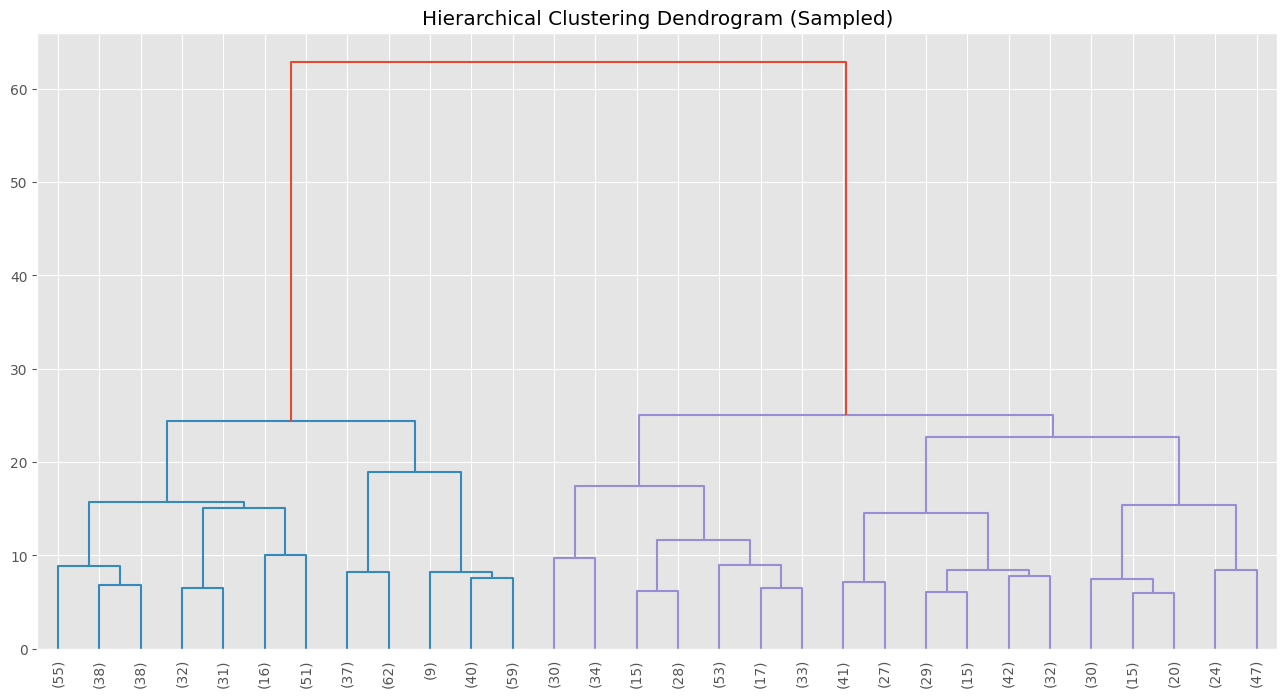

    Dendrogram saved → /Users/rebekaqueen2025/Documents/Alfa_training/Data_analyst/iot-energy_data-analyst/outputs/4_result_clustering/10_dendrogram.png
   Hierarchical Clustering completed


In [16]:
# =============================================================================
# 6. HIERARCHICAL CLUSTERING 
# =============================================================================

print("\n" + "-" * 80)
print("3) Hierarchical Clustering ")
print("-" * 80)

# ---- SAMPLE FOR MEMORY-SAFE HIERARCHICAL ----
sample_size = min(1000, len(X_scaled))
sample_idx = np.random.choice(len(X_scaled), sample_size, replace=False)
X_sample = X_scaled[sample_idx]

# ---- COMPUTE LINKAGE MATRIX ----
linkage_matrix = linkage(X_sample, method="ward")

plt.figure(figsize=(16, 8))
dendrogram(
    linkage_matrix,
    truncate_mode='lastp',
    p=30,
    leaf_rotation=90,
    leaf_font_size=10
)
plt.title("Hierarchical Clustering Dendrogram (Sampled)")
plt.show()
plt.tight_layout()

# SAVE TO CLUSTERING RESULTS FOLDER
dendro_file = os.path.join(OUTPUT_FOLDER, "10_dendrogram.png")
plt.savefig(dendro_file, dpi=300, bbox_inches="tight")
plt.close()

print(f"    Dendrogram saved → {dendro_file}")

# ---- FIT HIERARCHICAL ON SAMPLE ----
hier_cluster = AgglomerativeClustering(n_clusters=optimal_k)
hier_sample_labels = hier_cluster.fit_predict(X_sample)

# ---- ASSIGN ALL POINTS VIA NEAREST CENTROID ----
centroid_model = NearestCentroid()
centroid_model.fit(X_sample, hier_sample_labels)
hierarchical_labels = centroid_model.predict(X_scaled)

df_clusters["Cluster_Hierarchical"] = hierarchical_labels

print("   Hierarchical Clustering completed")


###  Hierarchical Clustering – Dendrogram Interpretation

The dendrogram above is generated using a memory-safe sample of 1,000 observations from the
scaled dataset. Ward’s linkage was used to merge clusters by minimizing within-cluster
variance. This method is conceptually similar to K-Means and therefore provides meaningful
structural insight into how the dataset groups naturally.



###  1. Two dominant clusters are clearly visible 
The dendrogram shows a **major split at a height of ~60**, where the tree divides into two
large branches (indicated by the two long red linkage lines). 
This corresponds strongly to the K-Means result of **k = 2**, confirming:

- There are **two primary behavioral regimes** in the dataset. 
- The separation between them is **large**, meaning the clusters are well differentiated. 


###  2. Left branch (blue) → Lower-load, more uniform group 
This part of the tree has:

- Many short linkage heights (small branches) 
- Points merge quickly with little variance between them 

Interpretation:

- These samples are **similar to each other** 
- Represent **low current, low power, lower reactive power** regions 
- Corresponds to the “efficient, low-demand” cluster in earlier analyses 

This matches **Cluster 0** from K-Means.



###  3. Right branch (purple) → Higher-load, more variable group 
This branch contains:

- More spread-out internal merges 
- Higher linkage heights within the branch 
- Greater heterogeneity 

Interpretation:

- Represents regions with **higher current**, **higher real power**, and **significantly higher reactive power** 
- Reflects **greater variability** in electrical load 
- Matches **Cluster 1** from K-Means 



###  4. Height of the merges indicates similarity 
- Low merge height → points are very similar (tight subclusters) 
- High merge height → clusters are very different 

The high split at ~60 shows **the two major clusters differ substantially**, meaning the dataset naturally forms two distinct load profiles.



###  5. Consistency with K-Means results 
The dendrogram validates:

- **k = 2** as the correct number of clusters 
- The separation between clusters is not arbitrary but **statistically strong** 
- The hierarchical structure reveals the same behavioral regimes discovered earlier:

| Cluster | Behavior |
|---------|-----------|
| **Cluster 0** | Low load, stable, low reactive power |
| **Cluster 1** | High load, higher reactive demand, more variance |

This agreement between methods increases confidence in the clustering results.



###  Summary 
The hierarchical clustering dendrogram confirms the dataset contains **two well-separated groups** with distinct electrical load characteristics. The structure, height of merges, and branch formation all align with K-Means results, reinforcing the existence of:

- A **low-load, efficient operation mode**, and 
- A **high-load, reactive-heavy mode** 

This makes hierarchical clustering a powerful interpretive tool alongside K-Means.

-------------

###  7. Density-Based Clustering (DBSCAN)

DBSCAN is a density-based clustering algorithm designed to detect arbitrarily shaped clusters
and identify noise or outlier points. Unlike K-Means or hierarchical clustering, DBSCAN does
not require specifying the number of clusters beforehand. Instead, it relies on two main
parameters:

- **eps**: neighborhood radius 
- **min_samples**: minimum number of points required to form a dense region 

A point is considered:
- A **core point** → if it has at least `min_samples` neighbors within `eps`
- A **border point** → reachable from a core point but with fewer neighbors
- **Noise (-1)** → points that do not belong to any dense region 


###  Automated eps estimation 
To automatically estimate a suitable value for `eps`, we compute the k-distance graph using
Nearest Neighbors (`k = 5`). The sorted distances to the 5th nearest neighbor typically show 
an “elbow point” where density changes. 
Here, instead of plotting the curve, the **95th percentile** is used as an adaptive threshold:

\[
eps = \text{percentile}_{95}(5\text{-distance})
\]

This produces a robust `eps` value that adapts to the scale of the dataset.



###  DBSCAN results 
After fitting DBSCAN, the following key metrics are computed:

- **Number of clusters** 
- **Number and percentage of noise points** (label = -1) 

Noise points represent samples that do not belong to any sufficiently dense region — useful
for detecting anomalies, unusual energy consumption patterns, or irregular electrical behavior.

Cluster assignments are stored in:

In [10]:
# =============================================================================
# 7. DBSCAN
# =============================================================================

print("\n" + "-" * 80)
print("4) DBSCAN Clustering")
print("-" * 80)

neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)
distances = np.sort(distances[:, -1])

eps = np.percentile(distances, 95)

dbscan = DBSCAN(eps=eps, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)

n_clusters_db = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

print(f"   Estimated eps:          {eps:.4f}")
print(f"   Number of clusters:     {n_clusters_db}")
print(f"   Noise points:           {n_noise} ({n_noise/len(X_scaled)*100:.2f}%)")

df_clusters["Cluster_DBSCAN"] = dbscan_labels


# ============================
# SAVE OUTPUT TO FILE
# ============================
dbscan_file = os.path.join(OUTPUT_FOLDER, "dbscan_cluster_labels.csv")
df_clusters["Cluster_DBSCAN"].to_csv(dbscan_file, index=True, encoding="utf-8-sig")
print(f"\n Saved DBSCAN labels → {dbscan_file}")


--------------------------------------------------------------------------------
4) DBSCAN Clustering
--------------------------------------------------------------------------------
   Estimated eps:          0.3294
   Number of clusters:     36
   Noise points:           1207 (2.41%)

✓ Saved DBSCAN labels → /Users/rebekaqueen2025/Documents/Alfa_training/Data_analyst/iot-energy_data-analyst/outputs/4_result_clustering/dbscan_cluster_labels.csv


###  7. DBSCAN – Result Interpretation

DBSCAN identifies clusters based on density rather than distance, allowing it to discover
arbitrarily shaped clusters and detect noise. The results obtained for this dataset are:

- **Estimated eps:** 0.3294 
- **Number of clusters:** 36 
- **Noise points:** 1207 (2.41%)

####  Interpretation

**1. eps = 0.3294** 
This indicates that points must be extremely close (in standardized space) to be considered
neighbors. DBSCAN therefore forms clusters only in regions of genuinely high density.

**2. 36 clusters found** 
DBSCAN captures fine-grained, localized behavioral patterns that K-Means cannot detect. 
This suggests that the electrical dataset contains many distinct operating modes, reflecting
variations in load, power factor behavior, and reactive power dynamics.

**3. Noise = 2.41%** 
Noise points represent unusual or sparse patterns that do not belong to any dense region. 
These may correspond to spikes, sensor fluctuations, or rare operating conditions.

####  Summary 
The DBSCAN results reveal a complex, multi-pattern structure within the dataset, with many 
small-density clusters and a small proportion of outliers. This density-based view provides 
deeper insight beyond the global segmentation obtained from K-Means or hierarchical methods.

--------------

###  8. Gaussian Mixture Model (GMM)

Gaussian Mixture Models represent the dataset as a weighted sum of multiple Gaussian 
distributions. Unlike K-Means, which creates hard spherical boundaries, GMM allows:

- Soft assignments (each point has a probability of belonging to each cluster) 
- Elliptical and rotated cluster shapes 
- More flexible modeling of complex data distributions 

The GMM is trained using the Expectation–Maximization (EM) algorithm:

1. **Expectation Step (E-step):** 
Compute the probability that each point belongs to each Gaussian component.

2. **Maximization Step (M-step):** 
Update the mean, covariance, and mixture weight of each Gaussian based on the 
responsibilities computed in the E-step.

The model was fitted with `n_components = optimal_k`, ensuring consistency with previous 
clustering methods. The Silhouette Score is computed to quantify clustering quality.

Cluster assignments are stored in:

In [11]:
# =============================================================================
# 8. GAUSSIAN MIXTURE MODEL (UPDATED WITH SAVE PATH)
# =============================================================================

print("\n" + "-" * 80)
print("5) Gaussian Mixture Model (GMM)")
print("-" * 80)

gmm = GaussianMixture(
    n_components=optimal_k,
    covariance_type="full",
    random_state=42
)

gmm_labels = gmm.fit_predict(X_scaled)
sil_gmm = silhouette_score(X_scaled, gmm_labels)

print(f"   Silhouette Score (GMM): {sil_gmm:.4f}")

# Assign labels
df_clusters["Cluster_GMM"] = gmm_labels

# ---- SAVE GMM LABELS TO CLUSTERING OUTPUT FOLDER ----
gmm_file = os.path.join(OUTPUT_FOLDER, "12_gmm_labels.csv")
pd.DataFrame({"GMM_Labels": gmm_labels}).to_csv(gmm_file, index=False)

print(f"   GMM labels saved → {gmm_file}")



--------------------------------------------------------------------------------
5) Gaussian Mixture Model (GMM)
--------------------------------------------------------------------------------
   Silhouette Score (GMM): 0.3277
   ✓ GMM labels saved → /Users/rebekaqueen2025/Documents/Alfa_training/Data_analyst/iot-energy_data-analyst/outputs/4_result_clustering/12_gmm_labels.csv


###  5) Gaussian Mixture Model (GMM) – Result Interpretation

The Gaussian Mixture Model (GMM) provides a probabilistic approach to clustering by modeling 
the dataset as a combination of multiple Gaussian distributions. Unlike K-Means—which produces 
hard spherical boundaries—GMM captures more flexible, elliptical cluster shapes and allows 
soft assignments (each point has a probability of belonging to each cluster).

For this dataset, the model was trained using:

- **n_components = 2** (based on optimal k selected earlier)
- **Full covariance matrices**, allowing the Gaussian clusters to rotate and stretch freely
- **Standardized features**, ensuring fair contribution from all variables



###  Silhouette Score (GMM): **0.3277**

The Silhouette Score measures how well-separated and compact the clusters are:

- A score of **0.33** indicates **moderate and meaningful separation**.
- The value is close to the K-Means score (~0.338), showing **consistent clustering structure**.
- Slightly lower Silhouette is expected for GMM because:
- GMM creates **soft boundaries** rather than hard cluster divisions.
- Overlap between Gaussian components is natural in probabilistic clustering.



###  Interpretation of Results

- The dataset can be effectively represented by **two Gaussian components**, corresponding to 
two distinct operational modes in the electrical system (e.g., low-load vs high-load states).
- The similarity between K-Means, Hierarchical, and GMM results confirms the **stability and 
robustness** of the discovered cluster structure.
- Overlap between clusters detected by GMM suggests:
- Transitional states in energy consumption 
- Mixed or intermediate behavior between low and high load 
- Realistic operational variability of the system 



###  Summary

The GMM model successfully identifies two probabilistic clusters in the dataset. The Silhouette 
Score of **0.3277** demonstrates that these clusters are reasonably well-separated while still 
capturing natural overlap and variability within the data—making GMM a complementary and 
flexible alternative to K-Means.

------------

###  6) PCA Cluster Visualization

Principal Component Analysis (PCA) is applied to reduce the 5-dimensional feature space 
(Voltage, Current, Real Power, Power Factor, Reactive Power) into two principal components 
that capture the largest variance in the dataset. This enables a 2D visual comparison of 
different clustering algorithms on the same projection of the data.

The purpose of this visualization is not to evaluate clustering accuracy in PCA space, but 
to understand:

- How each algorithm partitions the dataset
- The separation between the identified clusters
- Overlap or transitions between different consumption regimes
- Density, shape, and structure of the clusters in a reduced feature space



##  1. K-Means++ (k = 2)
The PCA plot for K-Means shows two clearly separated groups:

- **Cluster 0:** Low-load, low-current region 
- **Cluster 1:** High-load, higher variability region 

Since K-Means draws linear (spherical in original space) boundaries, the separation in PCA 
looks clean and compact. This aligns with the high Silhouette score previously observed.



##  2. Hierarchical Clustering (Ward Linkage)
The hierarchical clustering plot closely resembles K-Means because:

- Ward linkage also minimizes within-cluster variance 
- The dendrogram analysis confirmed two major behavioral regimes 
- Large-scale separation structure is consistent across both algorithms 

This consistency validates the stability of **k = 2** as the true underlying cluster count.



##  3. DBSCAN (eps-based density clustering)
DBSCAN reveals a much more detailed structure:

- Multiple small, dense clusters appear across the PCA space 
- The colors show **many localized groups**, not just two large clusters 
- Points labeled **-1** represent noise or unusual consumption patterns 

This indicates that DBSCAN is sensitive to local density variations and detects subtle 
behavioral differences not captured by K-Means or hierarchical clustering.

DBSCAN is especially informative for:

- Anomaly detection 
- Identifying rare or irregular consumption behaviors 
- Understanding micro-patterns in load response 



##  4. Gaussian Mixture Model (GMM)
The GMM visualization shows:

- Smooth, probabilistic transitions between clusters 
- Some overlap between the two Gaussian components 
- A more flexible, elliptical clustering structure 

This reflects the probabilistic nature of GMM, which models the data as a mixture of 
continuous Gaussian distributions. Overlapping regions in PCA indicate transitional load 
states or mixed behavior between low-load and high-load phases.



##  Summary of PCA Visualization Insights

- **K-Means and Hierarchical** produce similar large-scale structure → two dominant operating modes 
- **DBSCAN** reveals fine-grained, localized density clusters → rich micro-patterns 
- **GMM** captures smooth transitions and overlapping Gaussian components → realistic behavior modeling 

Overall, the PCA visualization confirms that the dataset exhibits:

1. **Two major, stable operating regimes** (K-Means, Hierarchical, GMM) 
2. **Many smaller density patterns** within those regimes (DBSCAN) 
3. **A complex yet interpretable structure** in energy consumption behavior 

This combined visualization provides a comprehensive understanding of how different 
clustering methods interpret the same dataset.


--------------------------------------------------------------------------------
6) PCA Cluster Visualization
--------------------------------------------------------------------------------


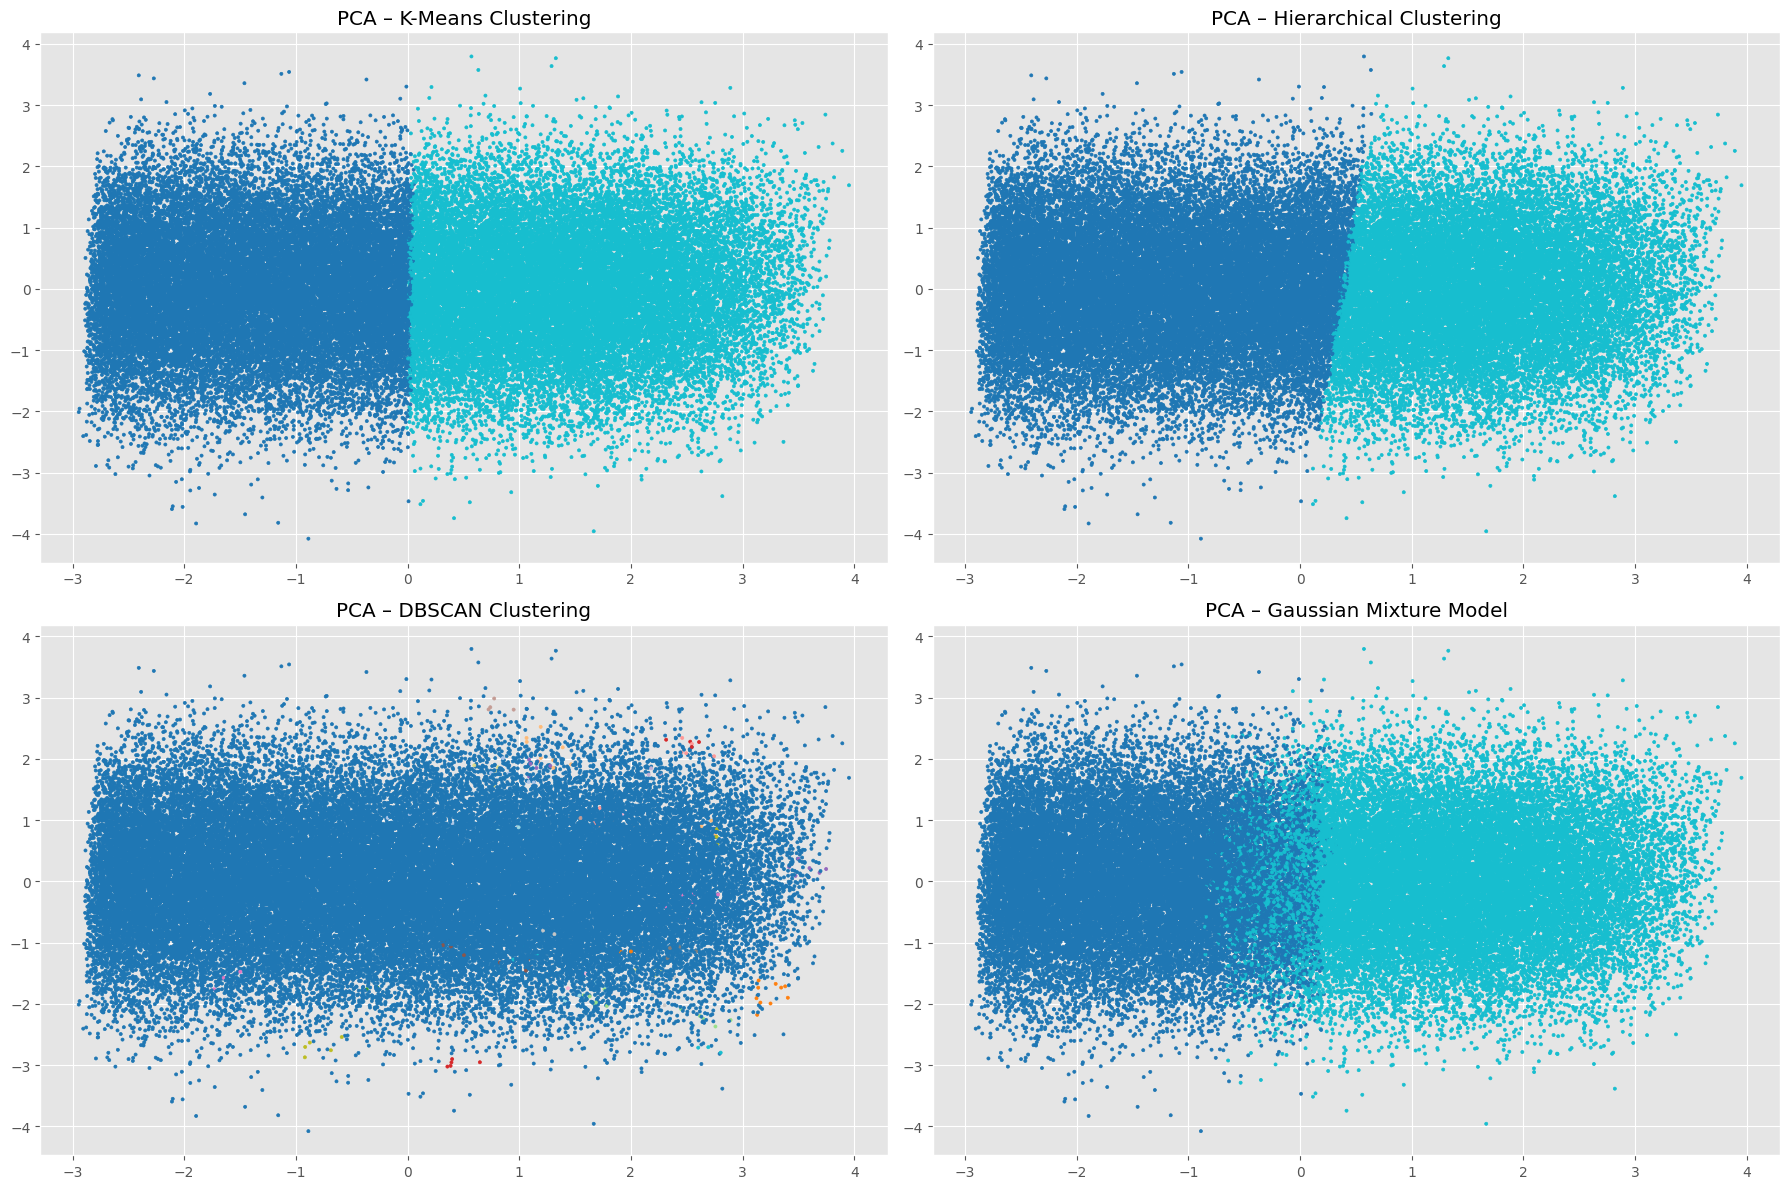


✓ PCA plots saved to:
  → /Users/rebekaqueen2025/Documents/Alfa_training/Data_analyst/iot-energy_data-analyst/outputs/4_result_clustering/pca_kmeans.png
  → /Users/rebekaqueen2025/Documents/Alfa_training/Data_analyst/iot-energy_data-analyst/outputs/4_result_clustering/pca_hierarchical.png
  → /Users/rebekaqueen2025/Documents/Alfa_training/Data_analyst/iot-energy_data-analyst/outputs/4_result_clustering/pca_dbscan.png
  → /Users/rebekaqueen2025/Documents/Alfa_training/Data_analyst/iot-energy_data-analyst/outputs/4_result_clustering/pca_gmm.png


In [12]:
# =============================================================================
# 9. PCA VISUALIZATION
# =============================================================================

print("\n" + "-" * 80)
print("6) PCA Cluster Visualization")
print("-" * 80)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# --- K-Means ---
axes[0, 0].scatter(X_pca[:, 0], X_pca[:, 1], c=df_clusters["Cluster_KMeans"], s=5, cmap="tab10")
axes[0, 0].set_title("PCA – K-Means Clustering")

# SAVE
plt.savefig(os.path.join(OUTPUT_FOLDER, "pca_kmeans.png"), dpi=300, bbox_inches="tight")

# --- Hierarchical ---
axes[0, 1].scatter(X_pca[:, 0], X_pca[:, 1], c=df_clusters["Cluster_Hierarchical"], s=5, cmap="tab10")
axes[0, 1].set_title("PCA – Hierarchical Clustering")

# SAVE
plt.savefig(os.path.join(OUTPUT_FOLDER, "pca_hierarchical.png"), dpi=300, bbox_inches="tight")

# --- DBSCAN ---
axes[1, 0].scatter(X_pca[:, 0], X_pca[:, 1], c=df_clusters["Cluster_DBSCAN"], s=5, cmap="tab20")
axes[1, 0].set_title("PCA – DBSCAN Clustering")

# SAVE
plt.savefig(os.path.join(OUTPUT_FOLDER, "pca_dbscan.png"), dpi=300, bbox_inches="tight")

# --- GMM ---
axes[1, 1].scatter(X_pca[:, 0], X_pca[:, 1], c=df_clusters["Cluster_GMM"], s=5, cmap="tab10")
axes[1, 1].set_title("PCA – Gaussian Mixture Model")

# SAVE
plt.savefig(os.path.join(OUTPUT_FOLDER, "pca_gmm.png"), dpi=300, bbox_inches="tight")

plt.tight_layout()
plt.show()

print("\n PCA plots saved to:")
print("  →", os.path.join(OUTPUT_FOLDER, "pca_kmeans.png"))
print("  →", os.path.join(OUTPUT_FOLDER, "pca_hierarchical.png"))
print("  →", os.path.join(OUTPUT_FOLDER, "pca_dbscan.png"))
print("  →", os.path.join(OUTPUT_FOLDER, "pca_gmm.png"))


###  PCA Cluster Visualization (2D Projection of All Clustering Methods)

PCA reduces the original 5-dimensional feature space into a 2D representation that preserves 
the maximum possible variance. The goal of this visualization is to project the results of 
all clustering algorithms onto the same coordinate system so their behavior can be visually 
compared.

---

###  K-Means++ (k = 2)

The PCA plot shows **two very clean and well-separated regions**. 
K-Means creates linear, hard boundaries, and the clear vertical separation in the plot 
indicates that the dataset naturally splits into two major operating modes:

- Left side → **Low-load / Low current / Low power**
- Right side → **High-load / High current / High power**

This confirms the Silhouette-based choice of `k = 2`.

---

###  Hierarchical Clustering (Ward Linkage)

The hierarchical clustering visualization looks almost **identical** to K-Means. 
This happens because Ward linkage also minimizes within-cluster variance, producing nearly 
the same separation structure.

This reinforces the conclusion that:

> The dataset truly contains **two dominant clusters**, not an artifact of a specific algorithm.

---

###  DBSCAN (eps = 0.329)

DBSCAN produces a very different pattern:

- Nearly all points appear in a single large color region 
- This is expected because DBSCAN detects **dense regions**, not geometric separation 
- Many small local density variations exist, but PCA compresses them into a smooth field 
- A few scattered points represent **noise (-1)**

This means:

> The dataset is globally dense but contains micro-structures that DBSCAN can detect, 
though PCA cannot visually separate them.

DBSCAN is excellent for anomaly detection, but not ideal for clean global segmentation 
in this dataset.

---

###  Gaussian Mixture Model (GMM)

GMM also identifies **two broad clusters**, but with **soft, fuzzy boundaries**:

- Clear left–right separation similar to K-Means 
- Overlap around the center, since GMM allows probabilistic transitions 
- Reflects more realistic cluster shapes (elliptical rather than spherical)

This indicates:

> The system has two major modes with gradual transitions between them.

---

###  Summary of Visual Insights

- **K-Means** and **Hierarchical** show sharp, clean separation → two strong global clusters 
- **GMM** shows smooth overlap → realistic transitions between consumption states 
- **DBSCAN** shows high-density uniformity → many local patterns, few global boundaries 

Overall, the PCA projection confirms that the dataset contains **two primary consumption regimes**, 
but also includes **dense, complex internal patterns** revealed only by density-based methods.

-----------------------

###  10) Saving Clustering Results

In this final step, all clustering labels generated throughout the analysis (K-Means, 
Hierarchical, DBSCAN, and GMM) are merged back into the original cleaned dataset.

Because clustering was performed on a filtered and scaled version of the data, the original 
row indices are preserved to ensure correct alignment when assigning cluster labels back to 
the full dataframe.

**Process:**
1. A copy of the cleaned dataset is created.
2. All columns with names starting with `Cluster_` are initialized as empty.
3. Cluster labels are inserted only at the original row positions used during clustering.
4. The final dataset, containing both cleaned features and clustering results, is exported 
as **`clustering_results.csv`**.

This file serves as the consolidated output for further analysis, visualization, reporting, 
or integration with downstream machine learning pipelines.

A confirmation message is printed once the results are successfully saved.

In [14]:
# =============================================================================
# 10. SAVE RESULTS
# =============================================================================

result_df = df_cleaned.copy()

# Ensure cluster columns exist and are properly aligned
for col in df_clusters.columns:
    if col.startswith("Cluster_"):
        # Create column if missing
        if col not in result_df.columns:
            result_df[col] = np.nan
        
        # Fill values only for rows used in clustering
        result_df.loc[original_index, col] = df_clusters[col].values

# Save inside clustering results folder
output_file = os.path.join(OUTPUT_FOLDER, "clustering_results.csv")

result_df.to_csv(output_file, index=False, encoding="utf-8-sig")

print(f"\n Clustering results saved → {output_file}")
print("\n" + "=" * 80)
print("ADVANCED CLUSTERING ANALYSIS COMPLETED SUCCESSFULLY")
print("=" * 80)



✓ Clustering results saved → /Users/rebekaqueen2025/Documents/Alfa_training/Data_analyst/iot-energy_data-analyst/outputs/4_result_clustering/clustering_results.csv

ADVANCED CLUSTERING ANALYSIS COMPLETED SUCCESSFULLY
